# Assignment 1 - Particle filter

- **Topic:** Designing a particle filter to estimate the position using magnetic field information
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  28-02-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment1_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your groupnumber


## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.



In [1]:
''' YOUR ANSWER HERE '''
groupNumber = 17

STUDENT_1_NAME = "Tom Lijding"
STUDENT_1_STUDENT_NUMBER = "6318037"

STUDENT_2_NAME = "Tjalle Aalbers"
STUDENT_2_STUDENT_NUMBER = "5374774"

# raise NotImplementedError()

## Objectives

#### Goal

The goal of this assignment is to estimate the position $ \mathbf{p}_t $ of an agent. The agent moves in an indoor environment and gets information about its approximate change in position $ \Delta \mathbf{p}_t $ at every time-step. To model this, you may assume a linear dynamic model of the form:
$$\mathbf{p}_{t + 1} = \mathbf{p}_t + \Delta \mathbf{p}_{t+1} + \mathbf{w}_{t+1}$$

Where:

- $\mathbf{p}_t$ is a 3-dimensional position vector of the agent at time $t$. 

- $\Delta \mathbf{p}_t$ is the change in positon.

- $\mathbf{w}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{Q})$ is Gaussian white noise.

- $ \mathbf{Q} \in \mathbb{R}^{3 \times 3} $ is the covariance of the process noise.

Since the information of the change in position $ \Delta \mathbf{p}_t$ contains errors, the position estimates from the dynamic model will drift. This means that over time, the agent will lose track of where it actually is. To remedy this, the agent is carrying a magnetometer, and has a map of the magnetic field. The magnetometer samples a measurement of the magnetic field $\mathbf{y}_t$ at every position $\mathbf{p}_t$. The map of the magnetic field is modeled by a non-linear function: a reduced rank Gaussian process (you do not need to understand, model or change the GP model, only to call the function evaluation). This results in the non-linear measurement model:
$$ \mathbf{y}_t = f(\mathbf{p}_t) + \mathbf{v}_t $$

Where:

- $\mathbf{y}_t$ is a 3-dimensional measurement vector of the magnetic field at time-step $t$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $\mathbf{v}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{R})$ is Gaussian white noise.

- $ \mathbf{R} \in \mathbb{R}^{3 \times 3} $ is the covariance of the measurement noise.


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times N}$ is a numpy array containing the magnetometer measurements
- `magnetometerInitialPosition` $\in \mathbb{R}^{3 \times 1}$ is a numpy array containing the initial position of the magnetometer
- `deltaMagnetometerPositions` $\in \mathbb{R}^{3 \times N}$ is a numpy array containing the change in position of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the particle filter you DO NOT need this dictionary.

In [2]:
''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt

import GP as GP
import linAlg as linAlg
import helper as helper
np.random.seed(groupNumber)

''' load in the data'''
(magnetometerMeasurements, 
 magnetometerInitialPosition, 
 deltaMagnetometerPositions,
 modelParameters) = helper.initializeParticleFilterAssignment(groupNumber % 29)

print(modelParameters['NtimeSteps'])

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\tomli\\Documents\\S&C\\Semester 3\\Probabilistic Sensor Fusion\\Github\\Probabilistic-Sensor-Fusion\\Probabilistic-Sensor-Fusion\\Assignment1\\processedData\\magMeas17.npz'

Below, a function is given to plot the map of the magnetic field and the ground truth position of the path taken by the agent. The agent does not know this path, it only has access to its initial position, the change in position at every time-step and the magnetometer measurements. 

Your first task it to use the agent's dynamic model to try and reconstruct the ground truth path. This is also known as dead reckoning and should be done using data stored in the variables `magnetometerInitialPosition` and `deltaMagnetometerPositions`. Save the agent's positions according to the dynamic model in the variable `deadReckoning` $\in \mathbb{R}^{3 \times N}$. Additionally, compare the magnetometer measurements with the map of the magnetic field. To achieve this, store the norm of the magnetic field at every time-step in the variable `magneticFieldNorm` $\in \mathbb{R}^{N}$.

This function should output three subfigures. Every subfigure includes the magnetic field map in the background. On the left the ground truth positions are plotted together with the dead reckoning positions. In the middle the magnetic field measurements are plotted with  the ground truth positions on top of the magnetic field map. On the right, the magnetic field measurements are plotted with  the ground truth positions over the magnetic field map.

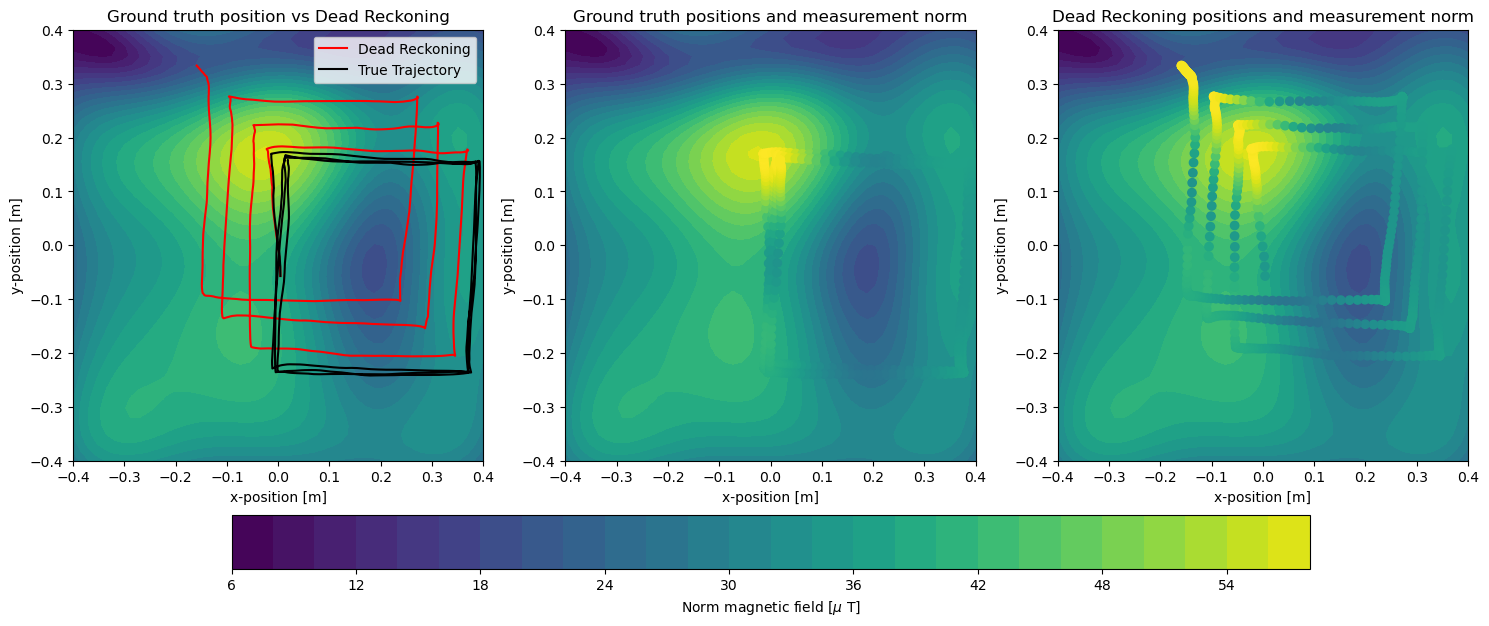

In [4]:
deadReckoning = np.zeros_like(deltaMagnetometerPositions)
deadReckoning[:, 0] = magnetometerInitialPosition.flatten() 

# Compute dead reckoning path
for t in range(1, deltaMagnetometerPositions.shape[1]):
    deadReckoning[:, t] = deadReckoning[:, t-1] + deltaMagnetometerPositions[:, t]
magneticFieldNorm = np.linalg.norm(magnetometerMeasurements, axis=0)

helper.makeInitialPositionPlots(deadReckoning, magneticFieldNorm, modelParameters)


### Discuss

Comment below on the three plots. 
- 	Does the dynamic model provide accurate enough information about the agent’s position? What will happen to the position of the agent if it moves for longer periods of time?
- Based on the magnetic field map shown in the background, explain why or why not the magnetic field is a good source of information for position estimation. 
- Explain why the measurements do or do not agree with the magnetic field map (for the middle and the right plots).

### Answer
- The dynamic model seems to have a slight drift to the upper west quadrant when compared to the true trajectory, defined by the dynamic model plus noise. Presumably, the position of the agent will drift more and more towards the upper left quadrant.
- Optimally, the magnetic field would have wildly varying values for each unique position. Utilizing this information, one could reconstruct the position of the agent perfectly just from measurements of the magnetic field (given no noise). Failing this, one would optimally look for a measurement field which does not have similar values along planned trajectories, as differentiating position along these trajectories would become difficult (has the agent moved or not?). Seeing the true trajectory of the agent, depending on the size of measurement noise, one would expect the agent to have the most difficulty reconstructing it's path along the right hand side of the map.
- As can obviously be seen from the middle plot, the measurements correspond to the plot as expected. The measurements of the magnetic field are being shown in the true position in which they are being measured. In the right plot, these measurements are being shown at incorrect positions and will thus obviously not correspond to the magnetic field map.


### Particle Filter Implementation

One way to reduce the positional drift observed in the figure above, is to use magnetometer measurements. To this end, you will design a particle filter. Your task is to fill in the following three functions.

#### Task
Fill in the `dynamicUpdate()` function according to the dynamic model given above. 

#### Note:
You do not have to change the inputs and outputs to the given functions.


In [5]:

def dynamicUpdate(particlePositions, 
                  deltaPosition,
                  processCovariance,
                  Nparticles):
    
     # Generate process noise from a multivariate normal distribution
    processNoise = np.random.multivariate_normal(mean=np.zeros(3), cov=processCovariance, size=Nparticles).T
    
    # Update each particle position
    for i in range(Nparticles):
        particlePositions[:,i] = particlePositions[:,i] + deltaPosition + processNoise[:,i]

    return particlePositions

#### Discuss

Comment on the role of the function of the dynamicUpdate in the particle filter

### Answer
The dynamicUpdate function of the particle filter serves as the sampling of the bootstrapped distribution given by

$$p_t^i = \sim p(p_t | p_{t-1}) \rightarrow p_t = p_{t-1} + \Delta p_t + w_t $$
where

$$w_t \sim \mathcal{N}(0_{3 \times 1},Q)$$

Note that we are using the bootstrapped version of the formula given by the slides, otherwise this distribution could be more complicated.

#### Task

Fill in the `measurementUpdate()` according to the measurement model given above. 

To implement the measurement model, you will need to make predictions of the magnetic field. You DO NOT need to create this function yourself. To make predictions, use the function `GP.makeMagneticFieldPrediction(positions, modelParameters)` function make sure the input `positions` $\in \mathbb{R}^{3 \times N} $. The output should be a matrix $\in \mathbb{R}^{3 \times N}$ magnetic field predictions for every input location.

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

def measurementUpdate(particlePositions, 
                      particleWeights,
                      magnetometerMeasurement,
                      measurementCovariance,
                      Nparticles,
                      modelParameters):
    
    ''' Measurement update for the particle filter '''
    predictionsMagneticFieldParticles = GP.makeMagneticFieldPrediction(particlePositions, modelParameters)  
    likelihoods = np.zeros(Nparticles)
    
    for i in range(Nparticles):
        likelihoods[i] = multivariate_normal.pdf(magnetometerMeasurement, mean = predictionsMagneticFieldParticles[:,i], cov = measurementCovariance)

    particleWeights *= likelihoods 

    return particlePositions, particleWeights

#### Discuss
Comment on the role of the function of the measurementUpdate in the particle filter

### Answer
The measurement update function serves multiple purposes. By first making a prediction of the magnetic field given our particle positions and defining a measurement covariance matrix, we can calculate what the probability is of the measurement given our particle position. Using this, the weight of the particle is updated. The particle weight is updated according to the formula 

$$\tilde w^i_t = p(y_t|p_t)w^i_{t-1}$$

Intuitively, we are updating our weights according to how likely it is that a particular particle is the true position, given our measurement. By normalizing all these updated weights, we have created a finite set of weights which describe the actual probability distribution of our particle.

The weights are not normalized in this function as this takes place in the particleFilter function.

#### Task

Fill in the remainder of the `particleFilter()` function. 


In [7]:
def particleFilter(particlePositions, 
                   deltaPosition, 
                   magnetometerMeasurement, 
                   processCovariance, 
                   measurementCovariance, 
                   Nparticles,
                   modelParameters):
    ''' Estimates position based on a known map'''

    particleWeights = np.full((Nparticles),1/Nparticles)

    if modelParameters['NtimeStepPF'] > 0:
        ''' Dynamic update '''
        particlePositions = dynamicUpdate(particlePositions, 
                                          deltaPosition, 
                                          processCovariance, 
                                          Nparticles)  


    ''' Measurement update '''
    (particlePositions, 
        particleWeights) = measurementUpdate(particlePositions, 
                                             particleWeights,
                                             magnetometerMeasurement, 
                                             measurementCovariance, 
                                             Nparticles,
                                             modelParameters)

    ''' Resampling '''    
    if np.sum(particleWeights) > 1e-12:
        particleWeights /= np.sum(particleWeights)
        indices = helper.systematicResample(particleWeights)
        particlePositions = particlePositions[:, indices]
    else:
        print('Degenerate particles: All the weights are close to zero !!!')
        particleWeights /= np.sum(particleWeights)
        indices = helper.systematicResample(particleWeights)

    meanPosition = np.mean(particlePositions, axis=1)
    maxPositionindex = np.argmax(particleWeights)
    maxPosition = particlePositions[:, maxPositionindex]

    return particlePositions, meanPosition, maxPosition


#### Discuss

Comment on the role of the function of the systematicResample in the particle filter

### Answer
The systematicResample function of the particlefilter chooses according to a certain law which samples are removed from the distribution (usually samples with low weights) and duplicates the most likely particles while removing the low weight particles. Specifically, the index returned from the function defines which of the particlePositions should be duplicated or removed. In this manner, all low probability particles which may have strayed away from the true location are removed, such that our total distribution (defined by the particles and their weights) is focused around the true position.

#### Task 4

Choose a suitable amount of particles, an initial position covariance, a suitable motion covariance and a suitable measurement covariance.

You could start with the following parameters
- `initalPositionCovariance` = np.eye(3)*0
- `Nparticles` = 100
- `processCovariance` = np.eye(3)*0.001**2
- `measurementCovariance` = np.eye(3)*1.5**2

To get better results, you might have to tune these. 

In [ ]:
''' Number of particles used in the particle filter '''
Nparticles = 100

''' Inital position covariance of the position '''
initalPositionCovariance = np.eye(3)*0.001

''' process covariance and measurement covariance '''
processCovariance = np.eye(3)*0.000004*2
measurementCovariance = np.eye(3)*1**2
'''Iteration 1: processCovariance = np.eye(3)*0.001*2'''
'''Iteration 2: processCovariance = np.eye(3)*0.01*2'''
'''Iteration 3: processCovariance = np.eye(3)*0.1*2'''
'''Iteration 4: measurementCovariance = np.eye(3)*3**2'''
'''Iteration 5: processCovariance = np.eye(3)*1*2
measurementCovariance = np.eye(3)*9**2'''

''' Initialize particle positions '''
particlePositions = np.random.multivariate_normal(magnetometerInitialPosition.flatten(),initalPositionCovariance,Nparticles)
particlePositions = np.transpose(particlePositions)

''' Create matrices to store mean and best particle position at every time-step'''
meanParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))
bestParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))

''' Initialize and run  the Particle Filter '''
modelParameters['NtimeStepPF'] = 0
for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosPF = deltaMagnetometerPositions[:,timendx]
    ymeasPF = magnetometerMeasurements[:,timendx]
    (particlePositions, 
     meanParticlePosition[:, timendx+1], 
     bestParticlePosition[:, timendx+1]) = particleFilter(particlePositions, 
                                                        deltaPosPF, 
                                                          ymeasPF, 
                                                          processCovariance, 
                                                          measurementCovariance, 
                                                          Nparticles,
                                                          modelParameters)

    modelParameters['NtimeStepPF'] += 1


### Visualize the output

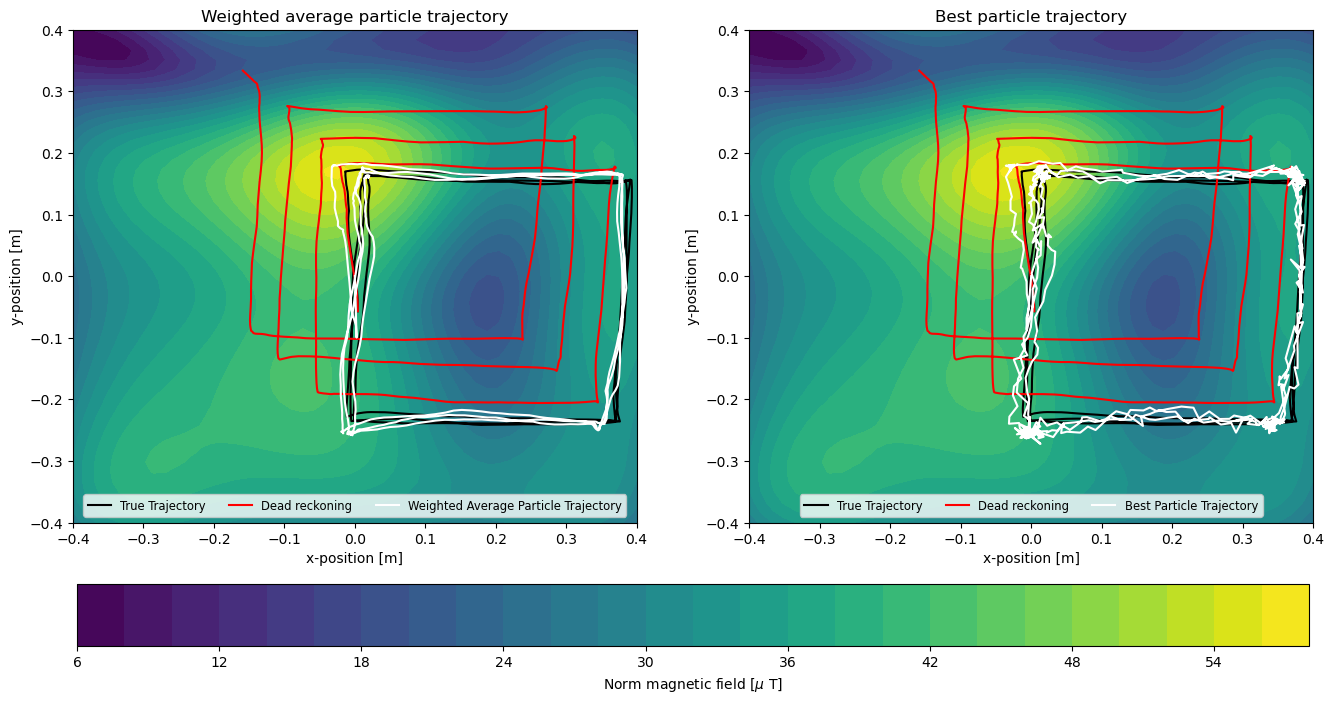

In [27]:
helper.makeParticleFilterPlots(deadReckoning, meanParticlePosition, bestParticlePosition, modelParameters)

#### Discuss

Elaborate on the two plots.
- Does the particle filter improve the position estimates?
- Are the weighted average particle trajectory and the best particle trajectory the same or different? Why is that the case?

### Answer

- The particle filter most definitely improves the position estimates. As can be seen from the plots the particle filter ensures that the drift is removed from our plot and that the true position is tracked. More specifically, the magnetic field map is used to supplement the dynamics of the model in tracking the position of the agent.
- The weighted average particle trajectory is different from the "best" particle trajectory. In our case, we have defined the "best" particle trajectory as the particle with the highest weight (and thus probability). Due to this, it can be clearly observed that the "best" particle trajectory is more erratic, presumably due to the fact that this best particle is not the same particle, but may jump from particle to particle. Furthermore, the distribution at any timestep (according to our model) is given by a Gaussian distribution, whose mean (average of all the weights) corresponds to the highest probability. Taking the highest weight particle is a more noisy version of finding this mean, and thus leads to a more noisy trajectory. In this case that our distribution has for example two peaks or more, in contrast to the one peak of our Gaussian, using the best particle might be more meaningful. 


#### Task

Play around with different parameters. Comment on what happens if we choose lower or higher values for
- `initalPositionCovariance`?
- `Nparticles`?
- `processCovariance`?
- `measurementCovariance`?

And reason about why this is the case

### Answer

- initialPositionCovariance: By changing the initialPositionCovariance the following happens: If the initial position covariance is chosen too large (on the order of 1 for example) the distribution of the particles will be too large, and too few particles will have substantial weights, leading to degenerate particles. One can choose the covariance matrix relatively small, since the true initial position is relatively close to the mean of the prior. However too small, with a processCovariance that is too big will lead the particles to diverge from the actual position and leads to degenerate particles.
- Nparticles: Increasing Nparticles leads to a smoother average particle trajectory, due to the fact that the distribution approaches the actual distribution we are attempting to approximate. However, no more how high we choose these particles, it may never be possible to perfectly track the actual position, since our magnetic field is not perfectly varied and there exist noise, leading to the actual distribution also having a mean that deviates from the actual position.
- processCovariance: By increasing the processCovariance, the randomness in the position of our particles is increased. This may be useful in the case that our model very badly describes the actual movement of the true agent, however at each time step, the difference between the prediction and the real particle is quite small, which means this can be taken small as well. Increasing it in our case leads to a more eratic average trajectory due to the randomness in the movement of the particles, while decreasing it leads to a more smooth following. Decreasing it too much will cause our particles to diverge from the actual position and thus become degenerate.
- measurementCovariance: The measurement covariance is the amount of randomness in the measurements of the particles. Perhaps the map is not perfect, or perhaps the measurements are noisy. In any case, if we take this too small, the probability of a measurement given the previous particle position will be near zero, leading to degenerate particles, while too large will lead to all measurements having a high probability, and the trajectory being erratic and untrue.



In [32]:
''' Number of particles used in the particle filter '''
Nparticles = 100

''' Inital position covariance of the position '''
initalPositionCovariance = np.eye(3)*0.001

''' process covariance and measurement covariance '''
processCovariance = np.eye(3)*0.000004*2
measurementCovariance = np.eye(3)*5**2


''' Initialize particle positions '''
particlePositions = np.random.multivariate_normal(magnetometerInitialPosition.flatten(),initalPositionCovariance,Nparticles)
particlePositions = np.transpose(particlePositions)

''' Create matrices to store mean and best particle position at every time-step'''
meanParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))
bestParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))


''' Initialize and run the Particle Filter '''
modelParameters['NtimeStepPF'] = 0
for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosPF = deltaMagnetometerPositions[:,timendx]
    ymeasPF = magnetometerMeasurements[:,timendx]
    (particlePositions, 
     meanParticlePosition[:, timendx+1], 
     bestParticlePosition[:, timendx+1]) = particleFilter(particlePositions, 
                                                          deltaPosPF, 
                                                          ymeasPF, 
                                                          processCovariance, 
                                                          measurementCovariance, 
                                                          Nparticles,
                                                          modelParameters)

    modelParameters['NtimeStepPF'] += 1


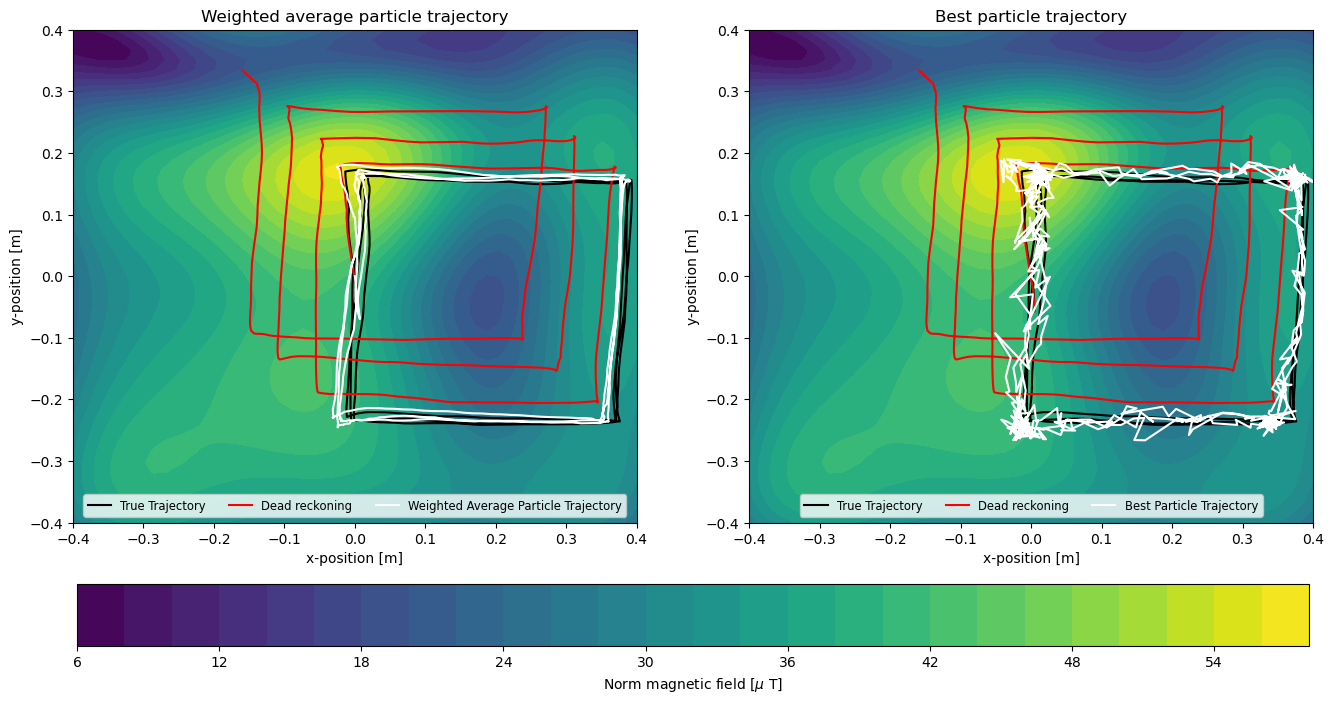

In [33]:
helper.makeParticleFilterPlots(deadReckoning, meanParticlePosition, bestParticlePosition, modelParameters)

#### Discuss

Comment on the reason for choosing a particle filter for this estimation problem.

### Answer
Our particular measurement function is non-linear and may lead to a multi-model likelihood (in other words, that the probability distribution is high in multiple places due to the ambiguous nature of our magnetic field map.) A classical Kalman Filter cannot represent this, while a particle filter can. These multimodalities are then collapsed at each new measurement, leading to a good estimation.